# ARIMA model

In [1]:
import pandas as pd

# Load the original dataset
df = pd.read_csv("../data/ts2024.csv", parse_dates=["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)

In [2]:
df

,DateTime,Date,Hour,X
0,2015-01-01,2015-01-01,0,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055
...,...,...,...,...
17539,2016-12-31 19:00:00,2016-12-31,19,NaN
17540,2016-12-31 20:00:00,2016-12-31,20,NaN
17541,2016-12-31 21:00:00,2016-12-31,21,NaN
17542,2016-12-31 22:00:00,2016-12-31,22,NaN


In [3]:
TEST_SIZE = 744
VAL_SIZE = 744

split_index = len(df) - TEST_SIZE

# Split datasets
df_trainval = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_val = df_trainval.iloc[-VAL_SIZE:].copy()
df_train = df_trainval.iloc[:-VAL_SIZE].copy()

print(f"Train: {df_train.shape}, Validation: {df_val.shape}, Test: {df_test.shape}")

Train: (16056, 4), Validation: (744, 4), Test: (744, 4)


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import numpy as np
import warnings

warnings.filterwarnings("ignore")

best_order = None
best_mae = float('inf')

results = []

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                model = ARIMA(df_train['X'], order=(p, d, q))
                model_fit = model.fit()
                preds = model_fit.forecast(steps=VAL_SIZE)
                mae = mean_absolute_error(df_val['X'], preds)
                results.append(((p, d, q), mae))
                print(f"ARIMA({p},{d},{q}) MAE: {mae:.4f}")
                if mae < best_mae:
                    best_mae = mae
                    best_order = (p, d, q)
            except:
                continue

print(f"\nBest ARIMA order: {best_order} with Validation MAE: {best_mae:.4f}")
arima_val_mae = best_mae

ARIMA(0,0,0) MAE: 0.0314
ARIMA(0,0,1) MAE: 0.0314
ARIMA(0,0,2) MAE: 0.0314
ARIMA(0,1,0) MAE: 0.0393
ARIMA(0,1,1) MAE: 0.0398
ARIMA(0,1,2) MAE: 0.0408
ARIMA(1,0,0) MAE: 0.0314
ARIMA(1,0,1) MAE: 0.0314
ARIMA(1,0,2) MAE: 0.0313
ARIMA(1,1,0) MAE: 0.0400
ARIMA(1,1,1) MAE: 0.0400
ARIMA(1,1,2) MAE: 0.0313
ARIMA(2,0,0) MAE: 0.0313
ARIMA(2,0,1) MAE: 0.0313
ARIMA(2,0,2) MAE: 0.0313
ARIMA(2,1,0) MAE: 0.0400
ARIMA(2,1,1) MAE: 0.0403
ARIMA(2,1,2) MAE: 0.0324

Best ARIMA order: (2, 0, 1) with Validation MAE: 0.0313


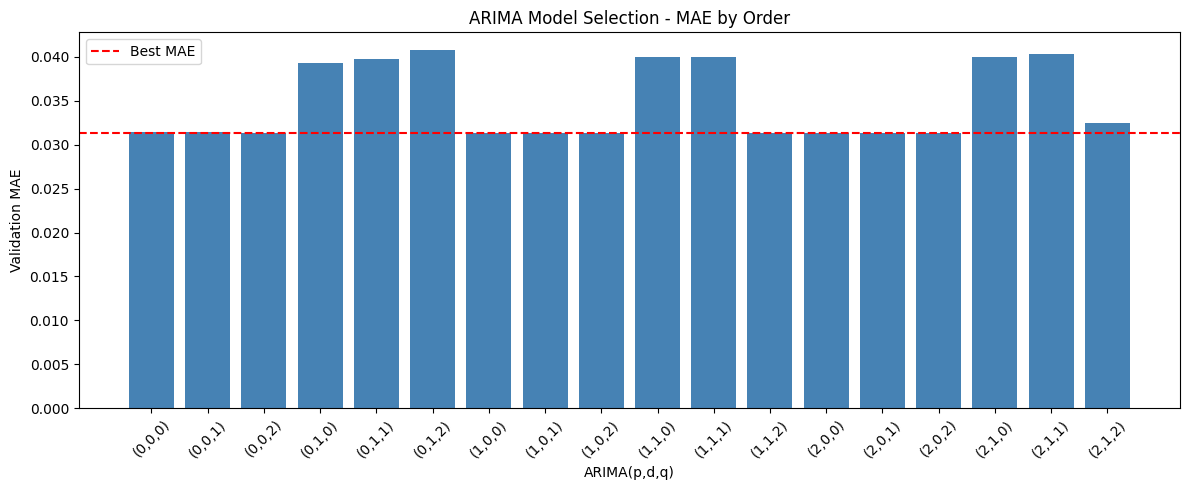

In [5]:
import matplotlib.pyplot as plt

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Order", "MAE"])
results_df["Label"] = results_df["Order"].apply(lambda x: f"({x[0]},{x[1]},{x[2]})")

# Plot bar chart
plt.figure(figsize=(12, 5))
plt.bar(results_df["Label"], results_df["MAE"], color='steelblue')
plt.axhline(results_df["MAE"].min(), color='red', linestyle='--', label='Best MAE')
plt.xticks(rotation=45)
plt.title("ARIMA Model Selection - MAE by Order")
plt.xlabel("ARIMA(p,d,q)")
plt.ylabel("Validation MAE")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Combine full training set (train + val)
full_train = df_trainval['X']

# Refit model on full trainval
final_model = ARIMA(full_train, order=best_order)
final_fit = final_model.fit()

# Forecast into test set (744 steps)
forecast_arima = final_fit.forecast(steps=TEST_SIZE)

In [7]:
forecast_arima

16800    0.019296
16801    0.029728
16802    0.039117
16803    0.046305
16804    0.050908
           ...   
17539    0.046313
17540    0.046313
17541    0.046313
17542    0.046313
17543    0.046313
Name: predicted_mean, Length: 744, dtype: float64

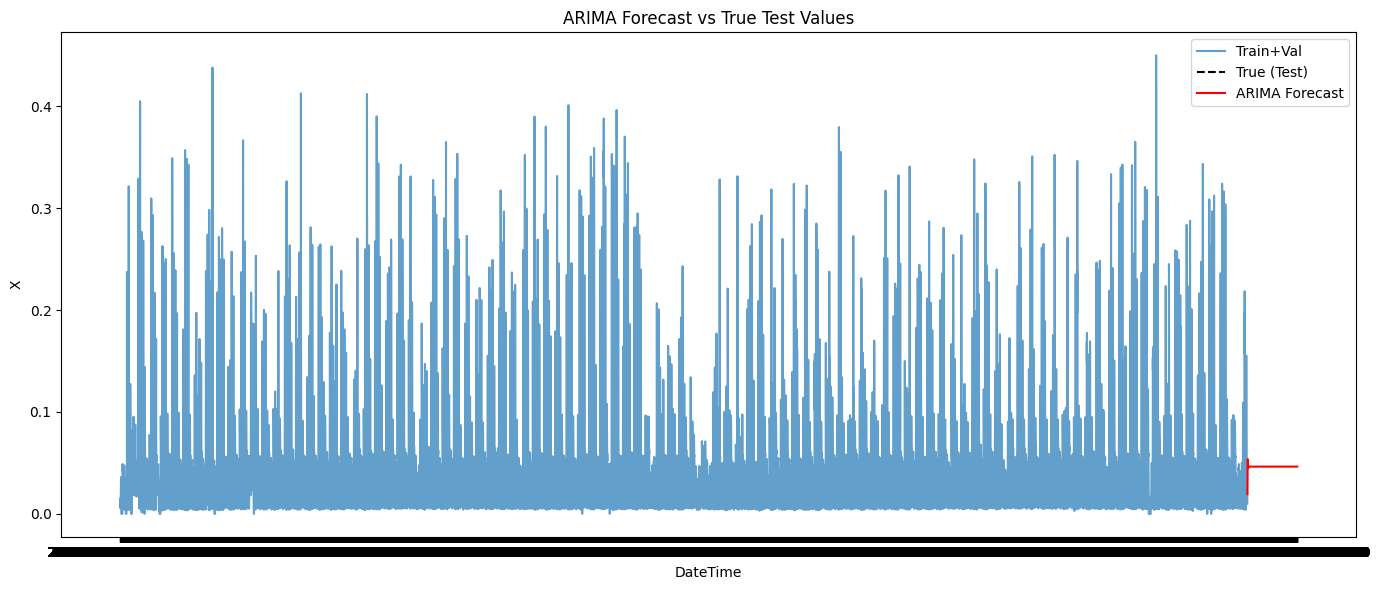

In [8]:
# Add predictions to test set for visualization
df_test = df_test.copy()
df_test["ARIMA_Pred"] = forecast_arima.values

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_trainval['DateTime'], df_trainval['X'], label="Train+Val", alpha=0.7)
plt.plot(df_test['DateTime'], df_test['X'], label="True (Test)", color='black', linestyle='--')
plt.plot(df_test['DateTime'], df_test['ARIMA_Pred'], label="ARIMA Forecast", color='red')
plt.title("ARIMA Forecast vs True Test Values")
plt.xlabel("DateTime")
plt.ylabel("X")
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1600x500 with 0 Axes>

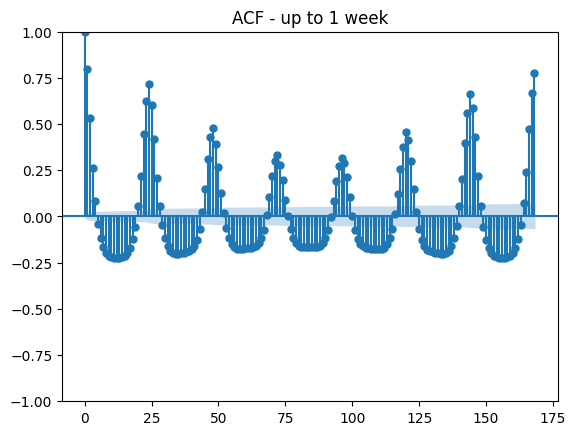

<Figure size 1600x500 with 0 Axes>

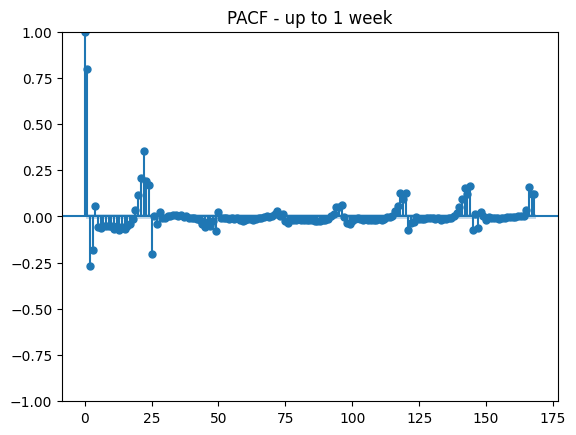

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16, 5))
plot_acf(df_trainval['X'].dropna(), lags=168)  # One week (24*7)
plt.title("ACF - up to 1 week")
plt.show()

plt.figure(figsize=(16, 5))
plot_pacf(df_trainval['X'].dropna(), lags=168, method='ywm')
plt.title("PACF - up to 1 week")
plt.show()

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX on training data
sarimax_model = SARIMAX(
    df_train['X'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit()

# Forecast validation
sarimax_val_forecast = sarimax_result.forecast(steps=VAL_SIZE)

In [11]:
from sklearn.metrics import mean_absolute_error

sarimax_val_mae = mean_absolute_error(df_val['X'], sarimax_val_forecast)
print(f"SARIMAX MAE on validation set: {sarimax_val_mae:.4f}")

SARIMAX MAE on validation set: 0.0186


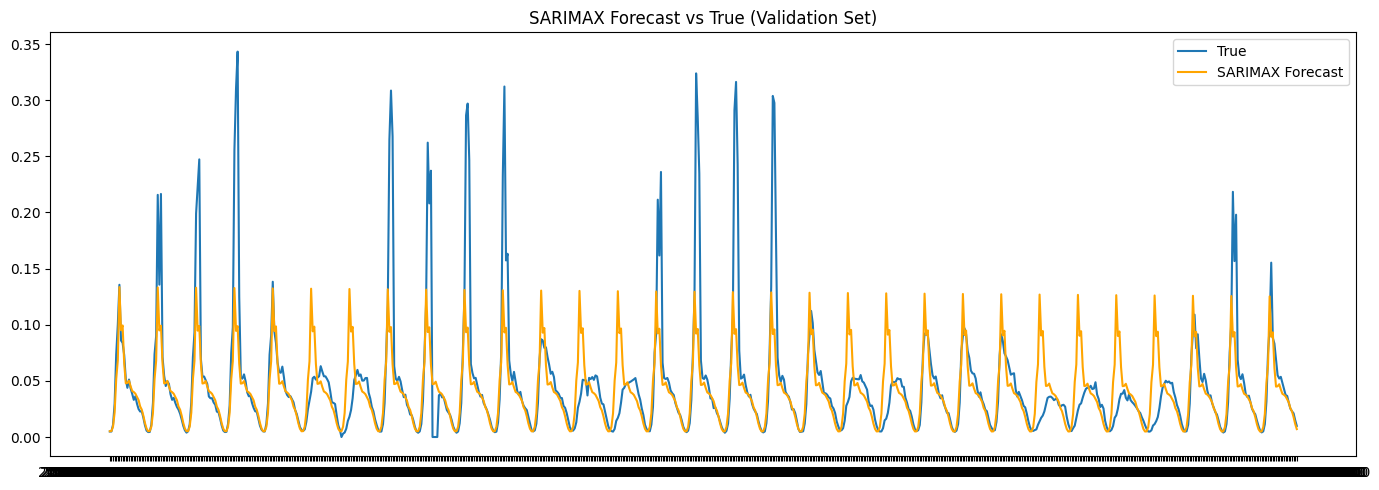

In [12]:
df_val = df_val.copy()
df_val["SARIMAX_Forecast"] = sarimax_val_forecast.values

plt.figure(figsize=(14, 5))
plt.plot(df_val['DateTime'], df_val['X'], label="True")
plt.plot(df_val['DateTime'], df_val['SARIMAX_Forecast'], label="SARIMAX Forecast", color='orange')
plt.title("SARIMAX Forecast vs True (Validation Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
sarimax_full = SARIMAX(
    df_trainval['X'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_full_result = sarimax_full.fit()

sarimax_forecast_test = sarimax_full_result.forecast(steps=744)

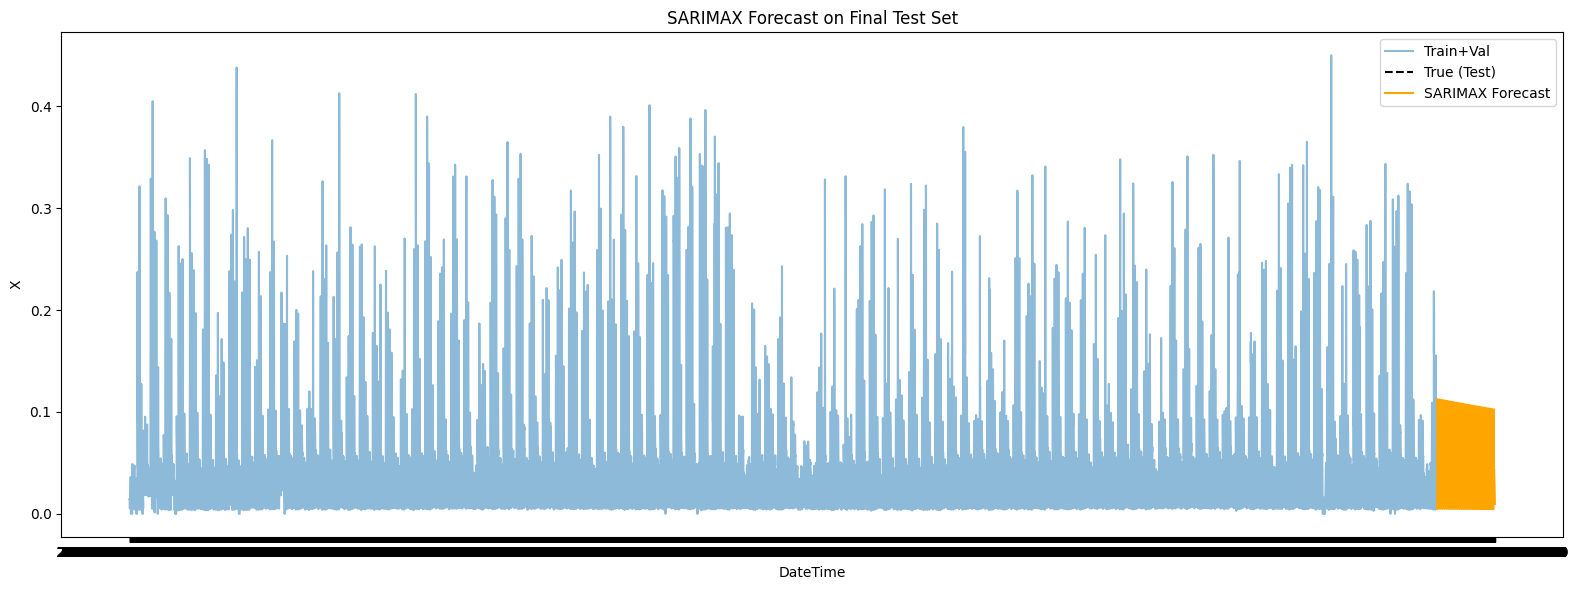

In [14]:
# Add SARIMAX forecast to test DataFrame
df_test = df_test.copy()
df_test["SARIMAX_Pred"] = sarimax_forecast_test.values

# Plot full timeline + forecast
plt.figure(figsize=(16, 6))
plt.plot(df_trainval['DateTime'], df_trainval['X'], label="Train+Val", alpha=0.5)
plt.plot(df_test['DateTime'], df_test['X'], label="True (Test)", linestyle='--', color='black')
plt.plot(df_test['DateTime'], df_test['SARIMAX_Pred'], label="SARIMAX Forecast", color='orange')
plt.title("SARIMAX Forecast on Final Test Set")
plt.xlabel("DateTime")
plt.ylabel("X")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df_trainval['DateTime'], y=df_trainval['X'],
                         mode='lines',
                         name='Train+Val',
                         line=dict(color='blue'),
                         opacity=0.5))

fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['X'],
                         mode='lines',
                         name='True (Test)',
                         line=dict(color='black', dash='dash')))

fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['SARIMAX_Pred'],
                         mode='lines',
                         name='SARIMAX Forecast',
                         line=dict(color='orange')))

# Update layout
fig.update_layout(
    title="SARIMAX Forecast on Final Test Set",
    xaxis_title="DateTime",
    yaxis_title="X",
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=1000,
    height=500
)

# Show the plot
fig.show()


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

seasonal_orders_to_try = [
    (1, 0, 1, 24),
    (1, 0, 2, 24),
    (2, 0, 1, 24)
    # Uncomment if you want to test weekly seasonality too
    # (1, 0, 1, 168),
    # (1, 0, 2, 168),
    # (2, 0, 1, 168),
]

best_sarimax_order = None
best_seasonal_order = None
best_sarimax_mae = float("inf")
sarimax_results = []

for seasonal_order in seasonal_orders_to_try:
    try:
        model = SARIMAX(
            df_train['X'],
            order=(1, 0, 1),  # fixed non-seasonal part
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        forecast = result.forecast(steps=VAL_SIZE)
        mae = mean_absolute_error(df_val['X'], forecast)
        sarimax_results.append((seasonal_order, mae))
        print(f"SARIMAX(1,0,1)x{seasonal_order} MAE: {mae:.4f}")
        if mae < best_sarimax_mae:
            best_sarimax_mae = mae
            best_sarimax_order = (1, 0, 1)
            best_seasonal_order = seasonal_order
    except Exception as e:
        print(f"Failed for seasonal_order={seasonal_order}: {e}")


SARIMAX(1,0,1)x(1, 0, 1, 24) MAE: 0.0186
SARIMAX(1,0,1)x(1, 0, 2, 24) MAE: 0.0186
SARIMAX(1,0,1)x(2, 0, 1, 24) MAE: 0.0186


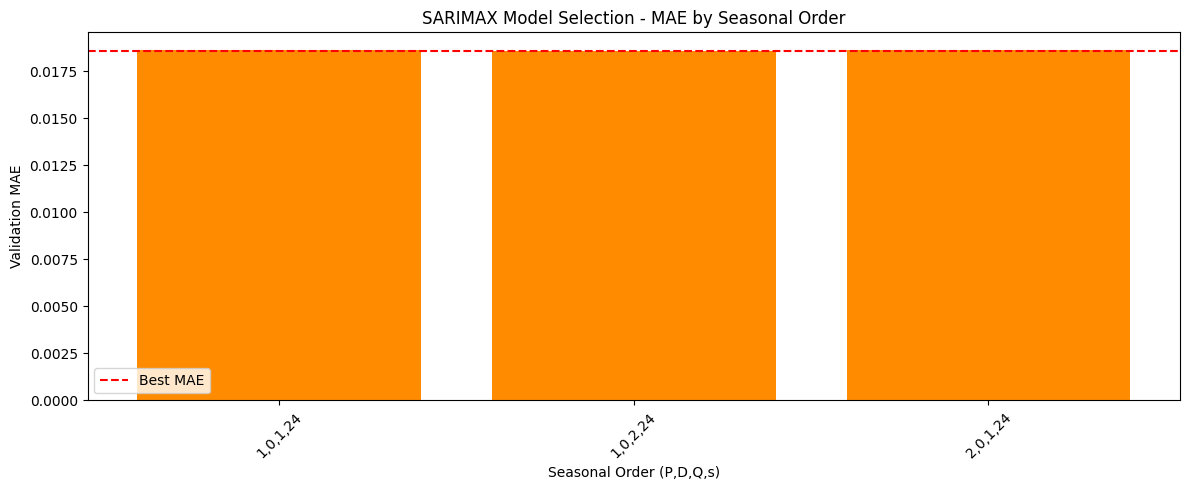

In [17]:
import matplotlib.pyplot as plt

labels = [f"{so[0]},{so[1]},{so[2]},{so[3]}" for so, _ in sarimax_results]
values = [mae for _, mae in sarimax_results]

plt.figure(figsize=(12, 5))
plt.bar(labels, values, color='darkorange')
plt.axhline(min(values), color='red', linestyle='--', label='Best MAE')
plt.title("SARIMAX Model Selection - MAE by Seasonal Order")
plt.xlabel("Seasonal Order (P,D,Q,s)")
plt.ylabel("Validation MAE")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Refit using best config
final_model = SARIMAX(
    df_trainval['X'],
    order=best_sarimax_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_result = final_model.fit()

sarimax_final_forecast = final_result.forecast(steps=744)


In [19]:
hourly_groups = {
    hour: df[df['Hour'] == hour].reset_index(drop=True)
    for hour in range(24)
}

hourly_test = {
    hour: df_test[df_test['Hour'] == hour].reset_index(drop=True)
    for hour in range(24)
}

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

hourly_forecasts = {}

for hour, hourly_df in hourly_groups.items():
    # Determine forecast horizon for this hour in test set
    test_horizon = len(hourly_test[hour])
    
    # Fit SARIMAX on training+val hourly data
    try:
        model = SARIMAX(
            hourly_df['X'],
            order=(1, 0, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_horizon)
        hourly_forecasts[hour] = forecast
    except Exception as e:
        print(f"Hour {hour} failed: {e}")
        hourly_forecasts[hour] = pd.Series([np.nan]*test_horizon)

In [21]:
# Create empty array for all 744 predictions
hourly_combined_forecast = np.empty(744)

# Fill in predictions for each hour in the correct slots
for hour in range(24):
    indices = df_test[df_test['Hour'] == hour].index
    hourly_combined_forecast[indices - df_test.index[0]] = hourly_forecasts[hour].values

# Add to test DataFrame
df_test["PerHour_Pred"] = hourly_combined_forecast

In [22]:
import plotly.graph_objects as go

fig = go.Figure()

# Train/Val
fig.add_trace(go.Scatter(x=df_trainval['DateTime'], y=df_trainval['X'],
                         mode='lines', name='Train+Val',
                         line=dict(color='blue'), opacity=0.5))

# True Test
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['X'],
                         mode='lines', name='True (Test)',
                         line=dict(color='black', dash='dash')))

# SARIMAX Forecast
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['SARIMAX_Pred'],
                         mode='lines', name='SARIMAX Forecast',
                         line=dict(color='orange')))

# Per-Hour Forecast
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['PerHour_Pred'],
                         mode='lines', name='Per-Hour Forecast',
                         line=dict(color='green')))

fig.update_layout(
    title="Comparison: SARIMAX vs Per-Hour Forecast",
    xaxis_title="DateTime",
    yaxis_title="X",
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


Correct hourly

In [23]:
# Group training+validation set by hour
hourly_groups = {
    hour: df_trainval[df_trainval['Hour'] == hour].reset_index(drop=True)
    for hour in range(24)
}

# Group test set by hour
hourly_test = {
    hour: df_test[df_test['Hour'] == hour].reset_index(drop=True)
    for hour in range(24)
}

In [24]:
from statsmodels.tsa.stattools import adfuller

print("ADF Test Results for Each Hourly Series (Train+Val):")
print("-" * 60)

for hour, series_df in hourly_groups.items():
    series = series_df['X'].dropna()
    result = adfuller(series)
    print(f"Hour {hour:02d} | ADF Statistic: {result[0]:.4f} | p-value: {result[1]:.4f} | Stationary: {'Yes' if result[1] < 0.05 else 'No'}")


ADF Test Results for Each Hourly Series (Train+Val):
------------------------------------------------------------
Hour 00 | ADF Statistic: -4.5661 | p-value: 0.0001 | Stationary: Yes
Hour 01 | ADF Statistic: -7.1788 | p-value: 0.0000 | Stationary: Yes
Hour 02 | ADF Statistic: -9.8543 | p-value: 0.0000 | Stationary: Yes
Hour 03 | ADF Statistic: -5.5032 | p-value: 0.0000 | Stationary: Yes
Hour 04 | ADF Statistic: -5.2825 | p-value: 0.0000 | Stationary: Yes
Hour 05 | ADF Statistic: -4.8254 | p-value: 0.0000 | Stationary: Yes
Hour 06 | ADF Statistic: -4.9345 | p-value: 0.0000 | Stationary: Yes
Hour 07 | ADF Statistic: -3.9595 | p-value: 0.0016 | Stationary: Yes
Hour 08 | ADF Statistic: -4.8308 | p-value: 0.0000 | Stationary: Yes
Hour 09 | ADF Statistic: -4.6163 | p-value: 0.0001 | Stationary: Yes
Hour 10 | ADF Statistic: -5.9207 | p-value: 0.0000 | Stationary: Yes
Hour 11 | ADF Statistic: -3.0279 | p-value: 0.0324 | Stationary: Yes
Hour 12 | ADF Statistic: -3.1087 | p-value: 0.0259 | Stati

In [25]:
from statsmodels.tsa.stattools import adfuller

print("ADF Test for Seasonal Differencing (s=7) on Hours 19–23")
print("-" * 60)

for hour in range(19, 24):
    series = hourly_groups[hour]['X'].dropna()
    
    # Apply seasonal differencing: x_t - x_{t-7}
    if len(series) > 7:
        seasonally_diffed = series.diff(7).dropna()
        result = adfuller(seasonally_diffed)
        print(f"Hour {hour:02d} | ADF Stat: {result[0]:.4f} | p-value: {result[1]:4f} | Stationary: {'Yes' if result[1] < 0.05 else 'No'}")
    else:
        print(f"Hour {hour:02d} | Not enough data for seasonal differencing")

ADF Test for Seasonal Differencing (s=7) on Hours 19–23
------------------------------------------------------------
Hour 19 | ADF Stat: -7.9315 | p-value: 0.000000 | Stationary: Yes
Hour 20 | ADF Stat: -7.3770 | p-value: 0.000000 | Stationary: Yes
Hour 21 | ADF Stat: -7.6902 | p-value: 0.000000 | Stationary: Yes
Hour 22 | ADF Stat: -7.7279 | p-value: 0.000000 | Stationary: Yes
Hour 23 | ADF Stat: -7.9046 | p-value: 0.000000 | Stationary: Yes


In [34]:
# Create hourly slices of validation set
hourly_val = {
    hour: df_val[df_val['Hour'] == hour].reset_index(drop=True)
    for hour in range(24)
}

# Forecast per-hour validation
hourly_val_forecasts = {}

for hour, hourly_df in hourly_groups.items():
    val_horizon = len(hourly_val[hour])
    try:
        model = SARIMAX(
            hourly_df['X'],
            order=(1, 0, 1),
            seasonal_order=(1, 0, 1, 7),  # Or use your dynamic seasonal_order
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        forecast = result.forecast(steps=val_horizon)
        hourly_val_forecasts[hour] = forecast
    except Exception as e:
        print(f"Hour {hour} failed on validation: {e}")
        hourly_val_forecasts[hour] = pd.Series([np.nan] * val_horizon)

# Combine into one array
val_combined_forecast = np.empty(len(df_val))

for hour in range(24):
    indices = df_val[df_val['Hour'] == hour].index
    val_combined_forecast[indices - df_val.index[0]] = hourly_val_forecasts[hour].values

# Store in df_val and compute MAE
df_val["PerHour_Pred"] = val_combined_forecast
perhour_val_mae = mean_absolute_error(df_val["X"], df_val["PerHour_Pred"])
print(f"Validation MAE - Per-Hour     : {perhour_val_mae:.4f}")


Validation MAE - Per-Hour     : 0.0246


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

final_hourly_forecasts = {}

for hour, hourly_df in hourly_groups.items():
    test_horizon = len(hourly_test[hour])
    
    # Use seasonal differencing D=1 for hours 19–23
    is_seasonally_diffed = hour >= 19
    
    try:
        model = SARIMAX(
            hourly_df['X'],
            order=(1, 0, 1),  # no non-seasonal differencing
            seasonal_order=(1, 1 if is_seasonally_diffed else 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_horizon)
        final_hourly_forecasts[hour] = forecast
    except Exception as e:
        print(f"Hour {hour} failed: {e}")
        final_hourly_forecasts[hour] = pd.Series([np.nan] * test_horizon)


In [27]:
import numpy as np

final_combined_forecast = np.empty(len(df_test))

for hour in range(24):
    indices = df_test[df_test['Hour'] == hour].index
    final_combined_forecast[indices - df_test.index[0]] = final_hourly_forecasts[hour].values

df_test["PerHour_Pred"] = final_combined_forecast

In [28]:
import plotly.graph_objects as go

fig = go.Figure()

# Train/Val
fig.add_trace(go.Scatter(x=df_trainval['DateTime'], y=df_trainval['X'],
                         mode='lines', name='Train+Val',
                         line=dict(color='blue'), opacity=0.5))

# True Test
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['X'],
                         mode='lines', name='True (Test)',
                         line=dict(color='black', dash='dash')))

# SARIMAX Forecast
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['SARIMAX_Pred'],
                         mode='lines', name='SARIMAX Forecast',
                         line=dict(color='orange')))

# Per-Hour Forecast
fig.add_trace(go.Scatter(x=df_test['DateTime'], y=df_test['PerHour_Pred'],
                         mode='lines', name='Per-Hour Forecast',
                         line=dict(color='green')))

fig.update_layout(
    title="Comparison: SARIMAX vs Per-Hour Forecast",
    xaxis_title="DateTime",
    yaxis_title="X",
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()

In [35]:
print(f"Validation MAE - ARIMA        : {arima_val_mae:.4f}")
print(f"Validation MAE - SARIMAX      : {sarimax_val_mae:.4f}")
print(f"Validation MAE - Per-Hour     : {perhour_val_mae:.4f}")

Validation MAE - ARIMA        : 0.0313
Validation MAE - SARIMAX      : 0.0186
Validation MAE - Per-Hour     : 0.0246


In [32]:
submission = pd.DataFrame({
    "DateTime": df_test["DateTime"],
    "ARIMA": df_test["SARIMAX_Pred"],     # SARIMAX forecast
    "UCM": np.nan,                         # Placeholder
    "ML": df_test["PerHour_Pred"]          # Per-hour model
})

submission.to_csv("../forecast_submission.csv", index=False)
print("Submission file saved to forecast_submission.csv")

Submission file saved to forecast_submission.csv


In [33]:
submission

,DateTime,ARIMA,UCM,ML
16800,2016-12-01,0.006420,NaN,0.006073
16801,2016-12-01 01:00:00,0.004667,NaN,0.004053
16802,2016-12-01 02:00:00,0.005481,NaN,0.004784
16803,2016-12-01 03:00:00,0.011077,NaN,0.011385
16804,2016-12-01 04:00:00,0.026364,NaN,0.031047
...,...,...,...,...
17539,2016-12-31 19:00:00,0.025052,NaN,0.030547
17540,2016-12-31 20:00:00,0.021722,NaN,0.028229
17541,2016-12-31 21:00:00,0.019823,NaN,0.027088
17542,2016-12-31 22:00:00,0.015186,NaN,0.021773
